In [28]:
curr_dir = f'/user_data/vayzenbe/GitHub_Repos/hemispace' #CHANGE AS NEEEDED CAUSE ITS FOR VLAAAD

import sys
sys.path.insert(0,curr_dir)
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd

import itertools
from nilearn import image, plotting, datasets
from nilearn.datasets import load_mni152_brain_mask, load_mni152_template
import nibabel as nib
import pdb
import os
import hemispace_params as params

#hide warning
import warnings
warnings.filterwarnings("ignore")


In [29]:
data_dir = params.data_dir
results_dir = params.results_dir
fig_dir = params.fig_dir

sub_info = params.sub_info
task_info = params.task_info
thresh = params.thresh

suf = params.suf
rois = params.rois
hemis = params.hemis


#load subject info
sub_info = pd.read_csv(f'{curr_dir}/sub_info.csv')

#extract just patients from group
#sub_info = sub_info[sub_info['group']=='patient']

#load mni mask
mni = image.load_img('/opt/fsl/6.0.3/data/standard/MNI152_T1_2mm_brain.nii.gz')
#binarize mni
mni_binary = image.math_img('img > 0', img=mni)

roi_dir = '/user_data/vayzenbe/GitHub_Repos/fmri/roiParcels/'




In [5]:
peak_coords = pd.read_csv(f'{results_dir}/neural_map/peak_coords.csv')

#calculate average distance between peak coordinates
avg_dist = []   

patient_data = peak_coords[peak_coords['group']=='patient']
control_data = peak_coords[peak_coords['group']=='control']

summary_df = pd.DataFrame(columns = ['sub','group','cond','hemi','position','x','y'])
n = 0
for cond in ['face']:
    print(f'Processing {cond}')

    #Determine number of positions and preferred hemi
    if cond == 'word' or cond == 'tool':
        positions = ['all']
        pref_hemi = 'left'

    elif cond == 'face' or cond == 'space':
        positions = ['posterior','anterior']
        pref_hemi = 'right'
    
    
    for position in positions:
        #get patient data for cond and position
        curr_patient_data = patient_data[(patient_data['cond']==cond) & (patient_data['position']==position)]
        #reset index
        curr_patient_data = curr_patient_data.reset_index(drop=True)

        #get control data for cond and position and preferred hemi
        curr_control_data = control_data[(control_data['cond']==cond) & (control_data['position']==position) & (control_data['hemi']==pref_hemi)]

        #compute distance between every patient coordinate with every control coordinate
        #and append as new column in patient data
        for i in range(len(curr_patient_data)):
            curr_dist = []
            for j in range(len(curr_control_data)):
                curr_dist.append(np.sqrt((curr_patient_data.iloc[i]['x']-curr_control_data.iloc[j]['x'])**2 + (curr_patient_data.iloc[i]['y']-curr_control_data.iloc[j]['y'])**2))

            #append mean dist to patient data
            curr_patient_data.loc[i,'dist'] = np.mean(curr_dist)

        pdb.set_trace()

Processing face
> /tmp/ipykernel_17310/3013854198.py(24)<module>()
     22 
     23 
---> 24     for position in positions:
     25         #get patient data for cond and position
     26         curr_patient_data = patient_data[(patient_data['cond']==cond) & (patient_data['position']==position)]



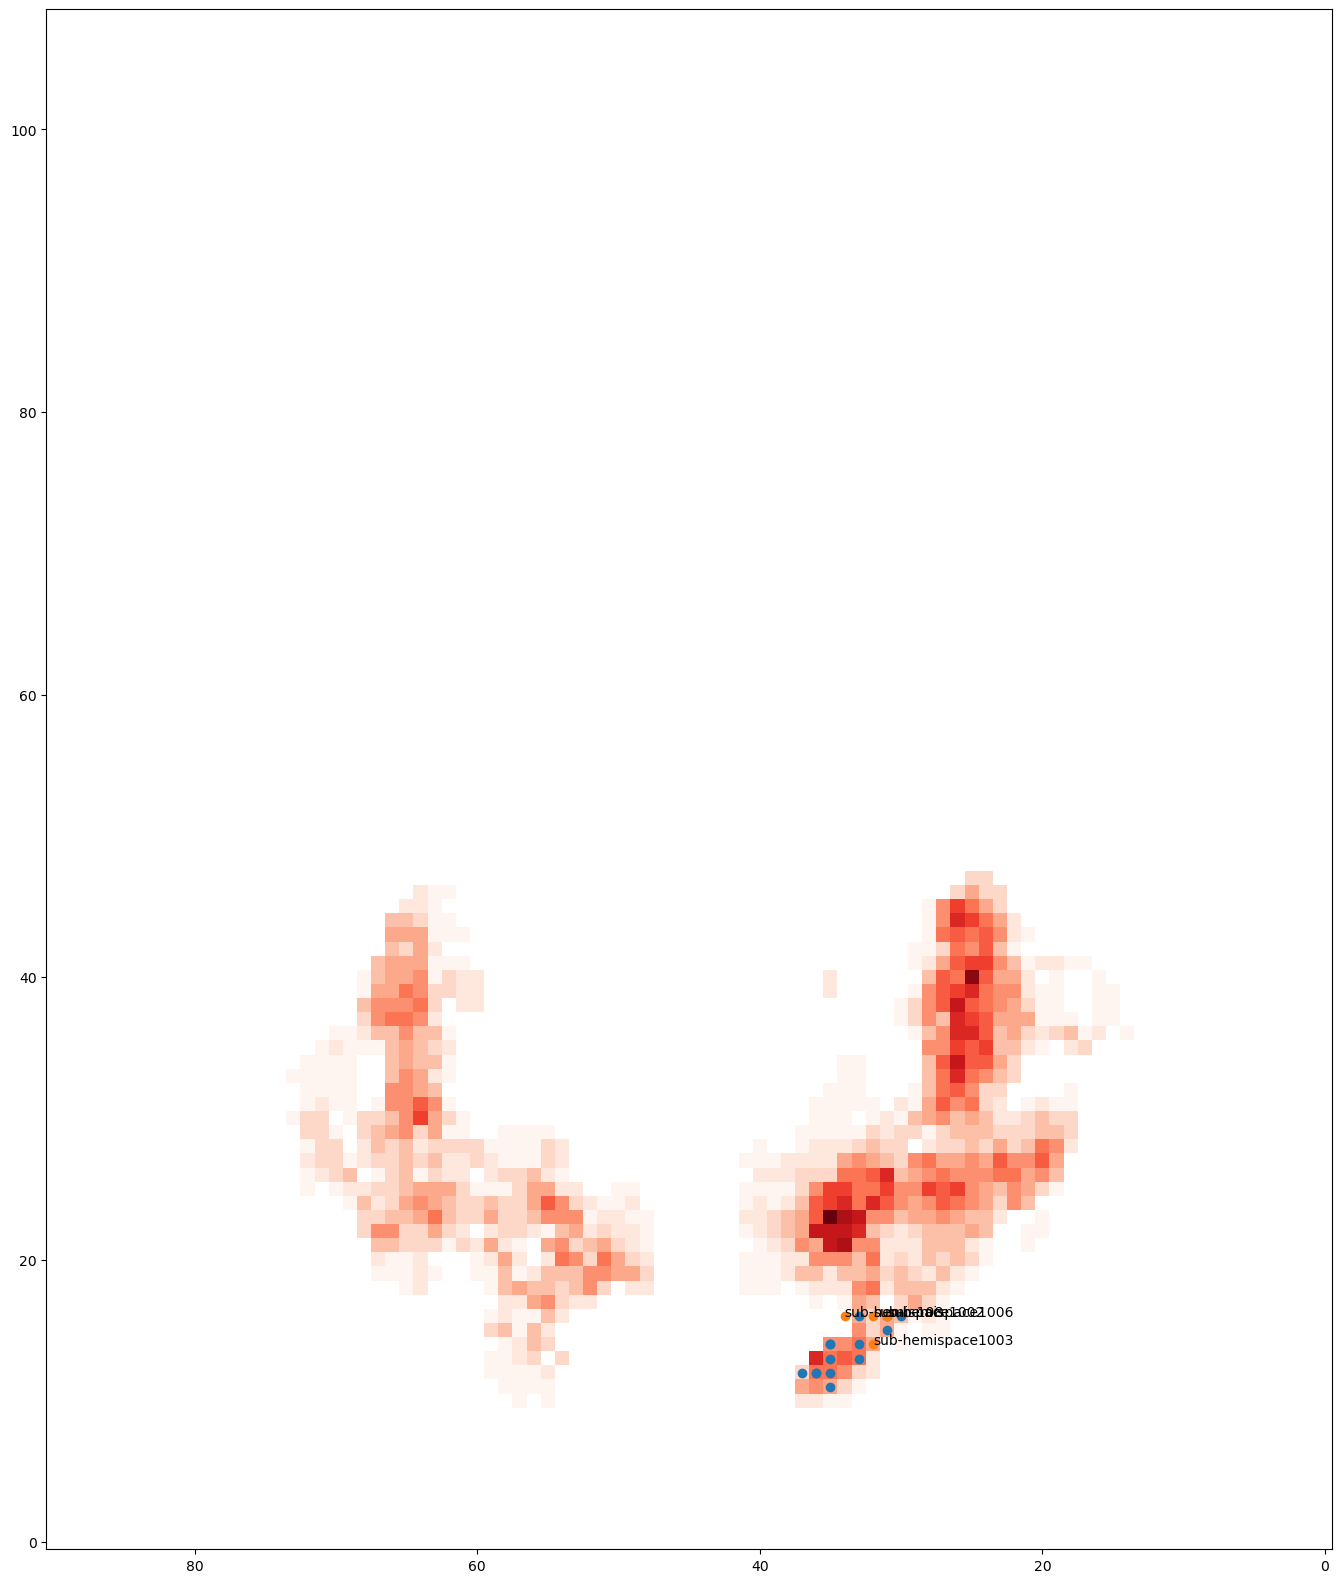

In [9]:
neural_map = np.load(f'{results_dir}/neural_map/{cond}_binary.npy')
#convert to percent of max
neural_map = neural_map/np.max(neural_map)

#keep top 10% th
#neural_map[neural_map < .5] = 0
#replace 0 with nan
neural_map[neural_map == 0] = np.nan

plt.figure(figsize=(20,20))

plt.imshow(neural_map, cmap='Reds')

plt.scatter(curr_control_data['y'],curr_control_data['x'])
plt.scatter(curr_patient_data['y'],curr_patient_data['x'])

#label each pateint point
for i in range(len(curr_patient_data)):
    plt.text(curr_patient_data.iloc[i]['y'],curr_patient_data.iloc[i]['x'],curr_patient_data.iloc[i]['sub'])

#flip x and y axes on plot
plt.gca().invert_yaxis()
plt.gca().invert_xaxis()



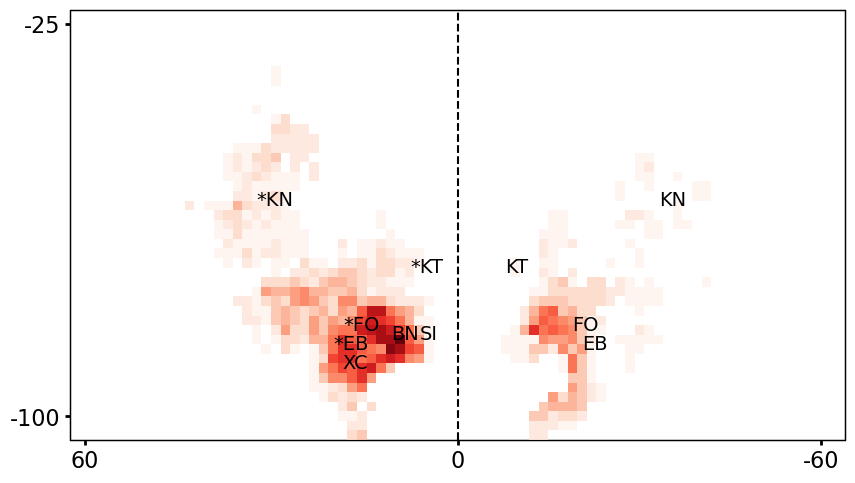

SI [17.]
SI [21.]
*SI [-17.]
*SI [-21.]
BI [18.]
*BI [-18.]
BN [15.]
BN [16.]
*BN [-15.]
*BN [-16.]
EB [-13.]
EB [-15.]
KT [-18.]
FO [-13.]
FO [-18.]
KN [-9.]
KN [-20.]


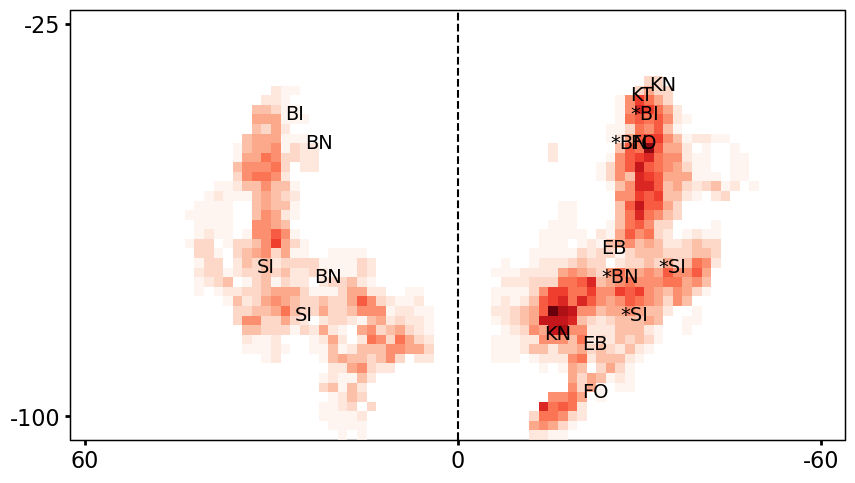

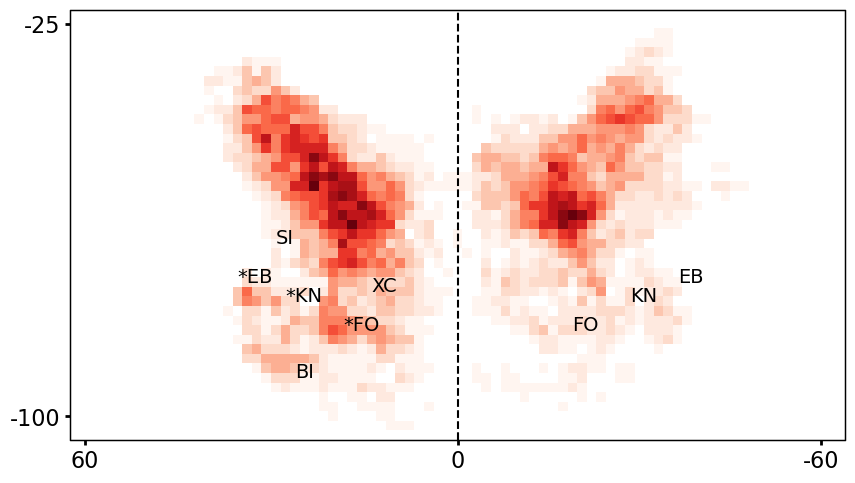

XC [6.]
XC [15.]
*XC [-6.]
*XC [-15.]
SI [17.]
*SI [-17.]
BI [14.]
BI [10.]
*BI [-14.]
*BI [-10.]
BN [15.]
BN [5.]
*BN [-15.]
*BN [-5.]
EB [-11.]
EB [-14.]
KT [-8.]
KT [-6.]
FO [-17.]
FO [-17.]


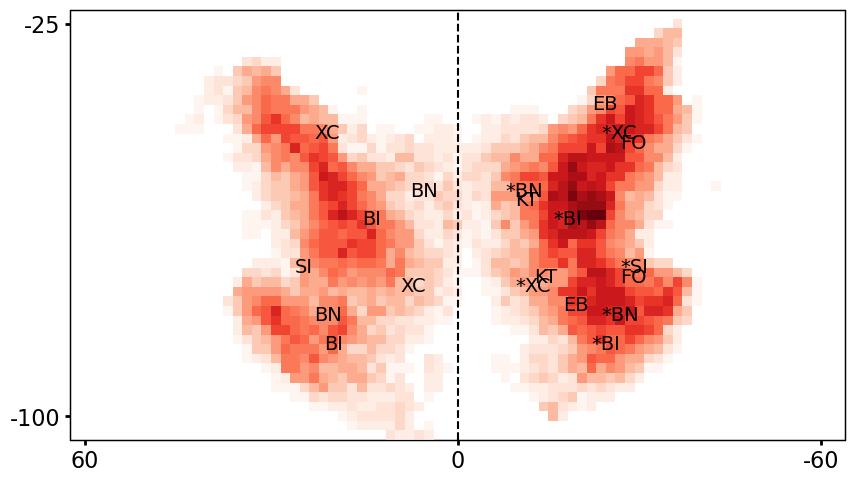

In [48]:
'''plot patient on controls'''

#set limits on matrix
min_val = [10]
max_val = [55]
y_cut = 5
x_cut = 5
mid_adjust = .5


#extract patient data
patient_subs = sub_info[sub_info['group']=='patient']

conds = ['word','face','tool','space']
pref_side = ['left','right','left','right']
midlines = [0, 17, 0, 17]

for cond, pref, split in zip(conds,pref_side, midlines):
    #load map
    neural_map = np.load(f'{results_dir}/neural_map/{cond}_binary.npy')

    #remove lower and upper bounds of matrix
    #neural_map = neural_map[y_cut:-y_cut, x_cut:-x_cut]
    neural_map = neural_map[min_val[0]:max_val[0], x_cut:-x_cut]

    #convert to percent of max
    neural_map = neural_map/np.max(neural_map)

    #keep top 10% th
    #neural_map[neural_map < .5] = 0
    #replace 0 with nan
    neural_map[neural_map == 0] = np.nan

    plt.figure(figsize=(10,6))

    plt.imshow(neural_map, cmap='Reds')
    #add dashed vertical line at midline
    plt.axvline(x=neural_map.shape[1]/2-mid_adjust, color = 'black', linestyle = '--')


    for sub, sub_code, hemi in zip(patient_subs['sub'],patient_subs['code'], patient_subs['intact_hemi']): 
        sub_dir = f'{data_dir}/{sub}/ses-01/derivatives/neural_map'
        #check if sub has neural map for cond
        if os.path.exists(f'{sub_dir}/{cond}_func.npy'):
            
            neural_map = np.load(f'{sub_dir}/{cond}_func.npy')
            neural_map = neural_map[min_val[0]:max_val[0], x_cut:-x_cut]
            #neural_map = neural_map[y_cut:-y_cut, x_cut:-x_cut]

            #mask out contralateral hemisphere
            if hemi == 'left':
                neural_map[:,:int(neural_map.shape[1]/2)] = 0
                text_color = '#ee7183'
            elif hemi == 'right':
                neural_map[:,int(neural_map.shape[1]/2):] = 0
                text_color = '#7398af'     


            if hemi == pref:
                sides = [1]
            else:
                sides = [1,2]

            

            for side in sides:
                if side ==1:
                    curr_map = neural_map
                    curr_code = sub_code

                else:
                    curr_map = np.flip(neural_map, axis = 1)
                    curr_code = f'*{sub_code}'


                #check if there should be a posterior and anterior ROI
                if split != 0:
                    for position in ['posterior','anterior']:
                        if position == 'posterior':
                            peak = np.max(curr_map[:split,:])
                        else:
                            peak = np.max(curr_map[split:,:])

                        if peak != 0:
                            peak_coord = np.where(curr_map == peak)

                            #print distance from midline
                            print(curr_code, peak_coord[1]-(neural_map.shape[1]/2 - mid_adjust))


                            #annotate heatmap with sub code at peak voxel
                            #plt.text(peak_coord[1], peak_coord[0], sub_code, color = 'black',fontsize=12,bbox=dict(facecolor=text_color,alpha = .6, edgecolor=text_color, boxstyle='round'))
                            plt.text(peak_coord[1], peak_coord[0], curr_code, color = 'black',fontsize=14)

                else:
                    peak = np.max(curr_map[split:,:])
                    if peak != 0:
                        peak_coord = np.where(curr_map == peak)

                        #annotate heatmap with sub code at peak voxel
                        #plt.text(peak_coord[1], peak_coord[0], sub_code, color = 'black',fontsize=12,bbox=dict(facecolor=text_color,alpha = .6, edgecolor=text_color, boxstyle='round'))
                        plt.text(peak_coord[1], peak_coord[0], curr_code, color = 'black',fontsize=14)

                


            

    #add title
    #plt.title(f'{cond} patient on controls')
    
    ax = plt.gca()

    ax.yaxis.set_ticks([2, curr_map.shape[0]-2])
    ax.yaxis.set_ticklabels([-100, -25])
    
    ax.xaxis.set_ticks([2,curr_map.shape[1]/2-mid_adjust, curr_map.shape[1]-2])
    ax.xaxis.set_ticklabels([-60, 0, 60])

    #increase font size of tick labels
    ax.tick_params(axis='both', which='major', labelsize=16)

    ax.patch.set_edgecolor('black')  
    ax.patch.set_linewidth(1)  

    ax.tick_params('both',  width=2, which='major')

    #flip y axis
    plt.gca().invert_yaxis()
    #flip x axis
    plt.gca().invert_xaxis()
    #plt.xticks([])
    #plt.yticks([])

    plt.savefig(f'{fig_dir}/maps/{cond}_patient_on_controls.png', dpi = 300, bbox_inches='tight', pad_inches=0.1)
    plt.show()
   
            

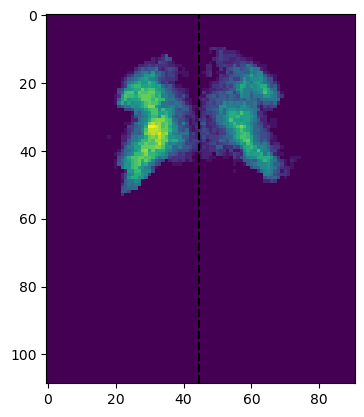

In [38]:
neural_map = np.load(f'{results_dir}/neural_map/{cond}_binary.npy')
plt.imshow(neural_map)
#plot vline at mid
plt.axvline(x=neural_map.shape[1]/2-1, color = 'black', linestyle = '--')

In [37]:
neural_map.shape[1]/2

45.5

In [31]:
neural_map

array([], shape=(45, 0), dtype=float64)

In [75]:
'''create whole brain map as template'''

sub = 'sub-hemispace1001'

sub_dir = f'{data_dir}/{sub}/ses-01'
task = 'loc'
cope =1

#check if zstat exists
zstat_path = f'{sub_dir}/derivatives/fsl/{task}/HighLevel{suf}.gfeat/cope{cope}.feat/stats/zstat1_reg.nii.gz'

if os.path.exists(zstat_path):
    #print(f'Processing {sub} {cond}, {roi_type}')

    #create output dir
    os.makedirs(f'{sub_dir}/derivatives/neural_map', exist_ok=True)

    #Load zstat
    zstat = image.load_img(mni_binary)

    #mask zstat with roi
    #zstat_masked = image.math_img('img1 * img2', img1=zstat, img2=roi)

    #threshold zstat
    #zstat_masked = image.threshold_img(zstat_masked, threshold=0, two_sided=True)

    #convert zstat to numpy
    func_np = zstat.get_fdata()


    #average across voxels in z dimension
    func_np = np.transpose(np.max(func_np, axis=2))

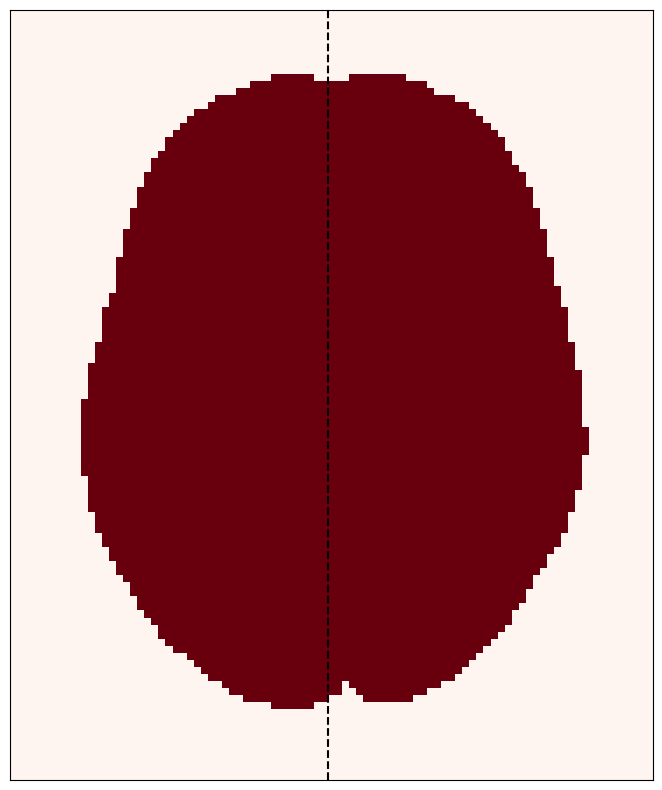

In [102]:

plt.figure(figsize=(12,10))
plt.imshow(func_np, cmap='Reds')
#add dashed vertical line at midline
plt.axvline(x=func_np.shape[1]/2, color = 'black', linestyle = '--')

#flip y axis
plt.gca().invert_yaxis()
#flip x axis
plt.gca().invert_xaxis()

#remove tick marks
#plt.locator_params(axis='y', nbins=3)
#plt.locator_params(axis='x', nbins=3)

plt.xticks([])
plt.yticks([])

#save 
plt.savefig(f'{fig_dir}/maps/template.png',  bbox_inches='tight', pad_inches=0)
plt.show()



In [99]:
(109/91)*10

11.978021978021978

In [86]:
x

array([-9.80000000e+01, -9.58222222e+01, -9.36444444e+01, -9.14666667e+01,
       -8.92888889e+01, -8.71111111e+01, -8.49333333e+01, -8.27555556e+01,
       -8.05777778e+01, -7.84000000e+01, -7.62222222e+01, -7.40444444e+01,
       -7.18666667e+01, -6.96888889e+01, -6.75111111e+01, -6.53333333e+01,
       -6.31555556e+01, -6.09777778e+01, -5.88000000e+01, -5.66222222e+01,
       -5.44444444e+01, -5.22666667e+01, -5.00888889e+01, -4.79111111e+01,
       -4.57333333e+01, -4.35555556e+01, -4.13777778e+01, -3.92000000e+01,
       -3.70222222e+01, -3.48444444e+01, -3.26666667e+01, -3.04888889e+01,
       -2.83111111e+01, -2.61333333e+01, -2.39555556e+01, -2.17777778e+01,
       -1.96000000e+01, -1.74222222e+01, -1.52444444e+01, -1.30666667e+01,
       -1.08888889e+01, -8.71111111e+00, -6.53333333e+00, -4.35555556e+00,
       -2.17777778e+00, -1.42108547e-14,  2.17777778e+00,  4.35555556e+00,
        6.53333333e+00,  8.71111111e+00,  1.08888889e+01,  1.30666667e+01,
        1.52444444e+01,  

In [81]:
109/(99-(-133))

0.4698275862068966

(array([19]), array([32])) 5.8690361976623535


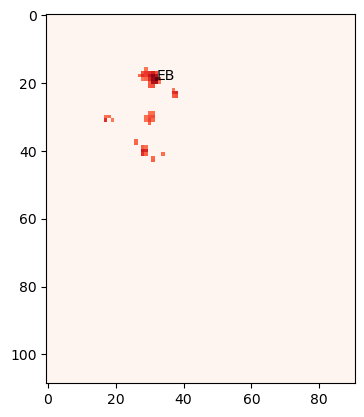

(array([17]), array([57])) 2.743250846862793


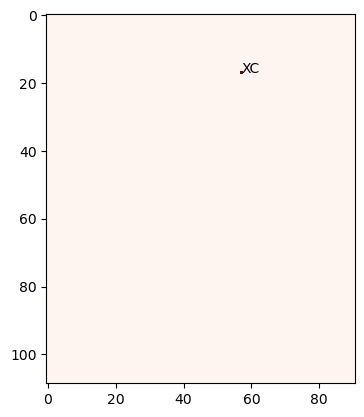

(array([27]), array([40])) 4.282557487487793


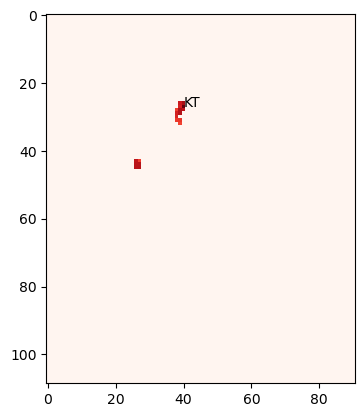

(array([20]), array([49])) 11.726729393005371


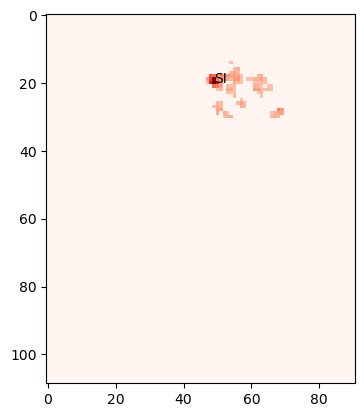

(array([21]), array([33])) 5.67073392868042


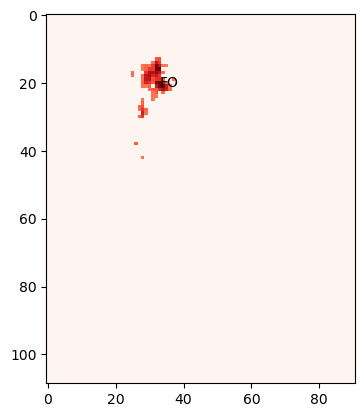

(array([31]), array([29])) 4.530336380004883


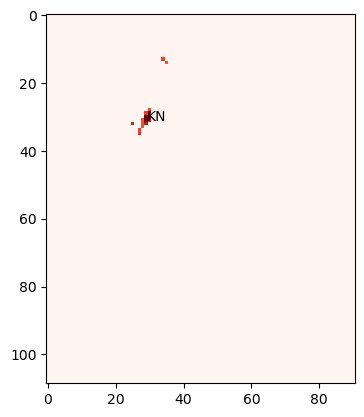

(array([20]), array([52])) 3.612633228302002


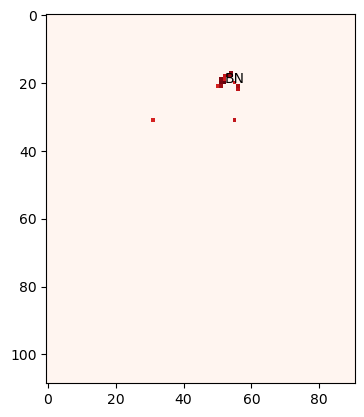

(array([20]), array([23])) 6.742310047149658


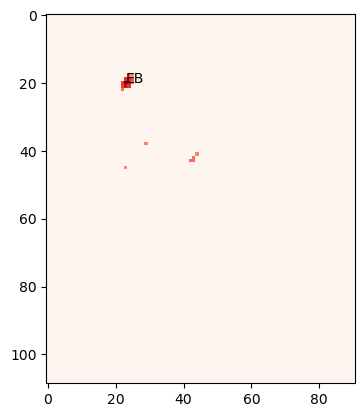

(array([15]), array([35])) 5.043622016906738


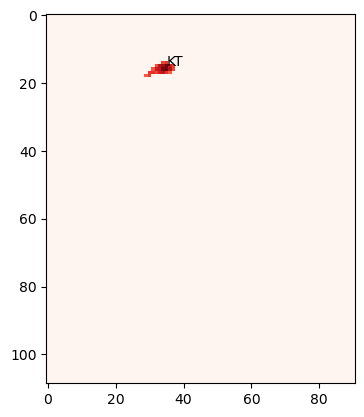

(array([24]), array([67])) 5.535463809967041


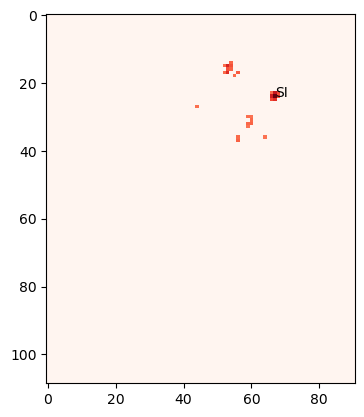

(array([33]), array([58])) 4.15933895111084


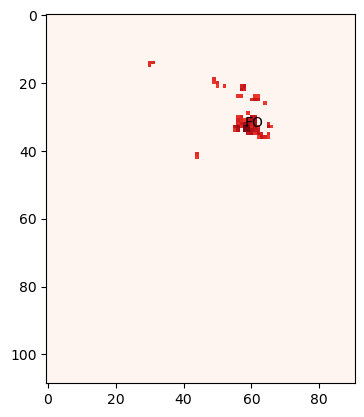

(array([23]), array([67])) 2.8016984462738037


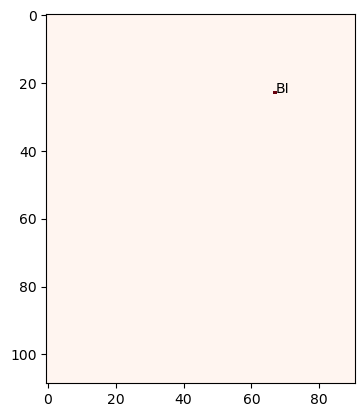

(array([16]), array([47])) 5.039006233215332


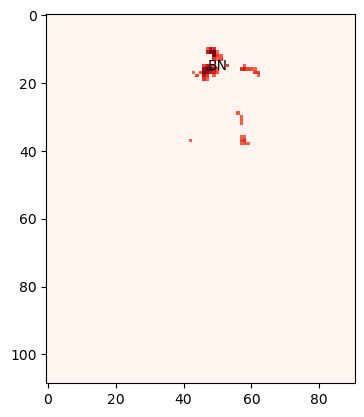

(array([18]), array([47])) 3.724236011505127


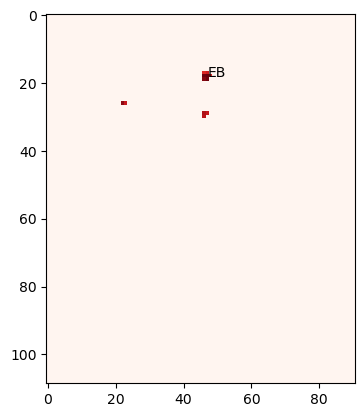

(array([25]), array([54])) 3.44669508934021


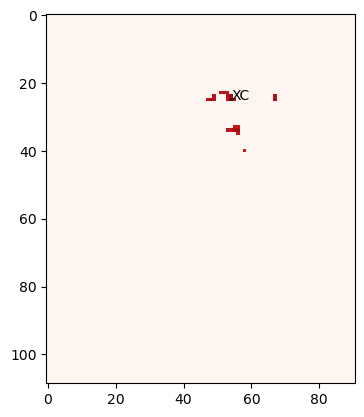

(array([30]), array([64])) 2.7454025745391846


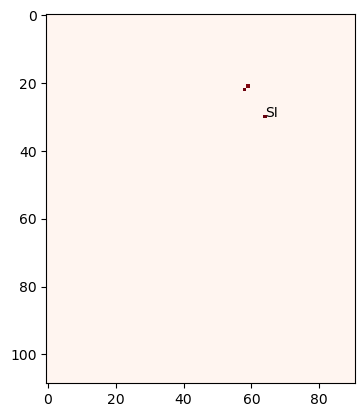

(array([21]), array([33])) 3.707045793533325


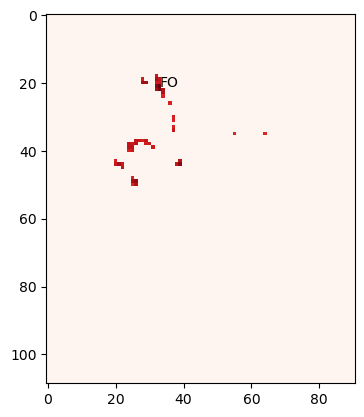

(array([16]), array([62])) 4.15679931640625


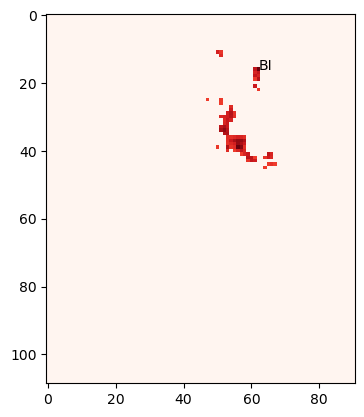

(array([24]), array([27])) 3.692370653152466


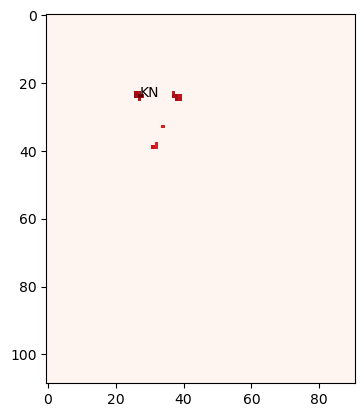

(array([44]), array([31])) 4.188579082489014


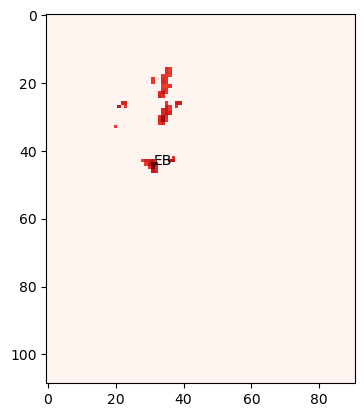

(array([41]), array([60])) 4.320613384246826


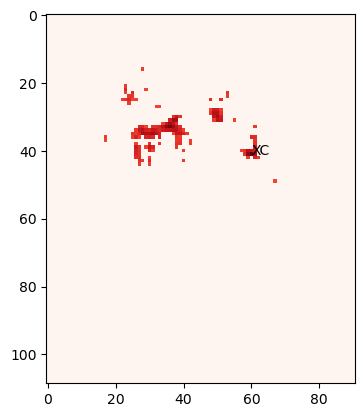

(array([34]), array([39])) 10.45568561553955


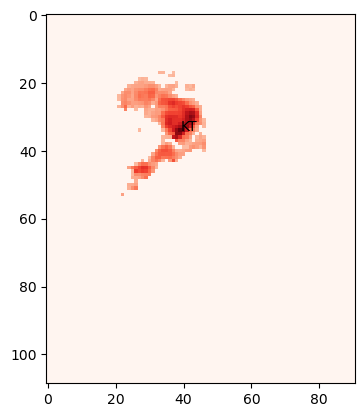

(array([27]), array([62])) 2.7104287147521973


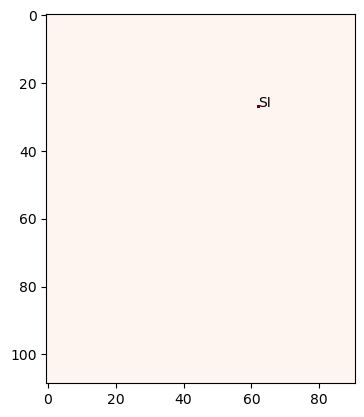

(array([40]), array([28])) 3.409635305404663


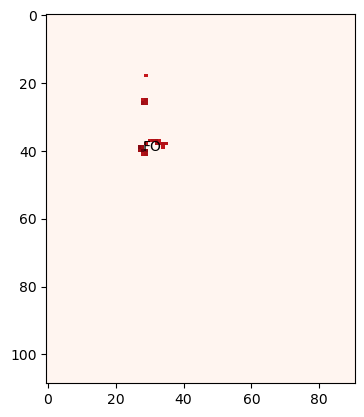

(array([32]), array([55])) 7.869563102722168


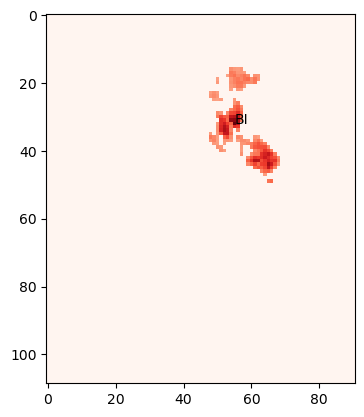

(array([35]), array([60])) 3.9059855937957764


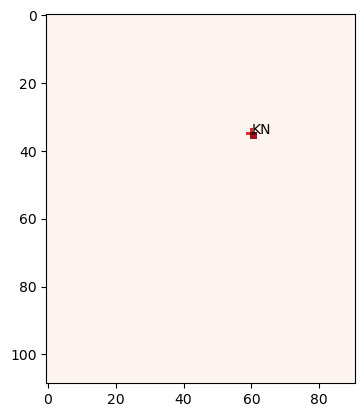

(array([35]), array([50])) 4.070951461791992


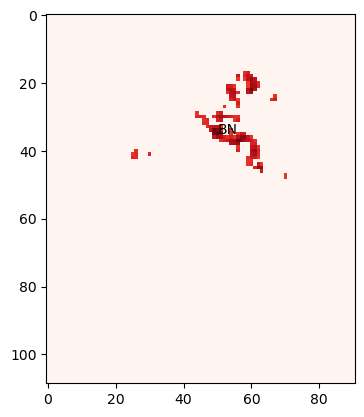

In [136]:
'''
plot individual patient data
'''


#extract patient data
patient_subs = sub_info[sub_info['group']=='patient']

conds = ['word','face','tool','space']

for cond in conds:
    for sub, sub_code in zip(patient_subs['sub'],patient_subs['code']):
        sub_dir = f'{data_dir}/{sub}/ses-01/derivatives/neural_map'

        #check if sub has neural map for cond
        if os.path.exists(f'{sub_dir}/{cond}_func.npy'):
            neural_map = np.load(f'{sub_dir}/{cond}_func.npy')

            #convert 0 to nan
            #neural_map[neural_map==0] = np.nan
            if np.max(neural_map) != 0:
                #ax = sns.heatmap(neural_map,cmap='Reds')
                plt.imshow(neural_map, cmap = 'Reds')
                #find coordinate of peak voxel
                peak = np.where(neural_map == np.max(neural_map))
                print(peak, np.max(neural_map))

                #annotate heatmap with sub code at peak voxel
                plt.text(peak[1], peak[0], sub_code, color = 'black')

                #add title
                #plt.gca().invert_yaxis()
                #flip x axis
                #plt.gca().invert_xaxis()
                plt.show()
            else:
                continue

            
            

In [125]:
peak = np.where(neural_map == np.max(neural_map))
print(peak, np.max(neural_map))

(array([35]), array([50])) 4.070951461791992


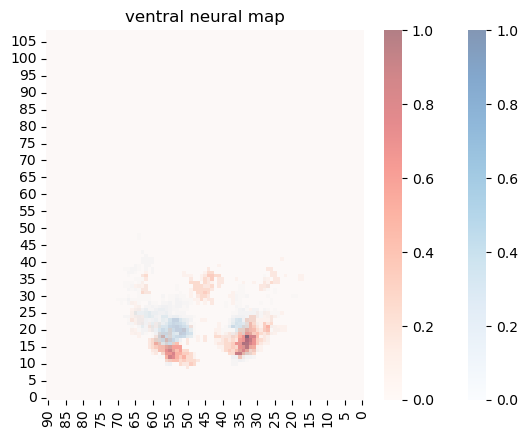

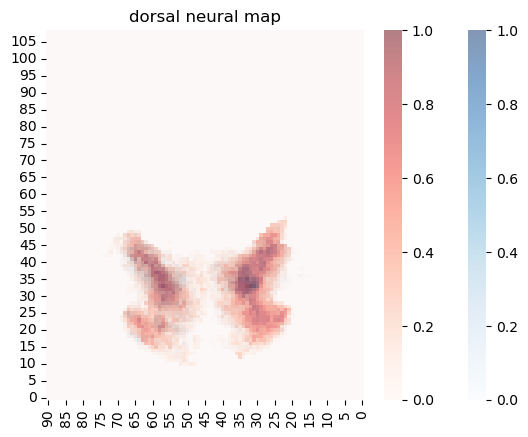

In [ ]:
rois = ['ventral', 'dorsal']

all_conds = [['word','face'],['tool','space']]
colors = ['Blues','Reds']

rn = 0
for conds in all_conds:
    n= 0
    for cond in conds:

        neural_map = np.load(f'{results_dir}/neural_map/{cond}_binary.npy')
        #convert to percent of max
        neural_map = neural_map/np.max(neural_map)

        #keep top n%
        #neural_map[neural_map < .5] = np.nan


        ax = sns.heatmap(neural_map, cmap=colors[n],alpha = .5)        
        
        n += 1

    #add title
    ax.set_title(f'{rois[rn]} neural map')
    #flip y axis
    ax.invert_yaxis()
    #flip x axis
    ax.invert_xaxis()
    plt.show()
    rn += 1

    

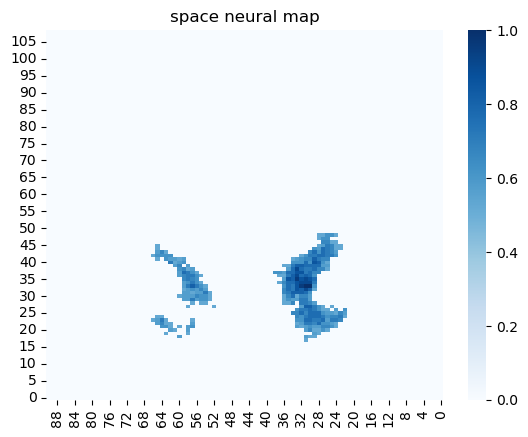

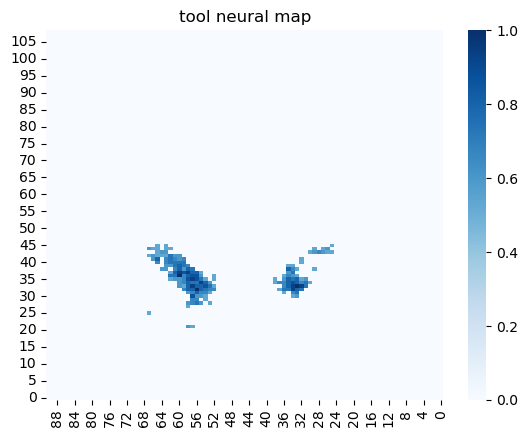

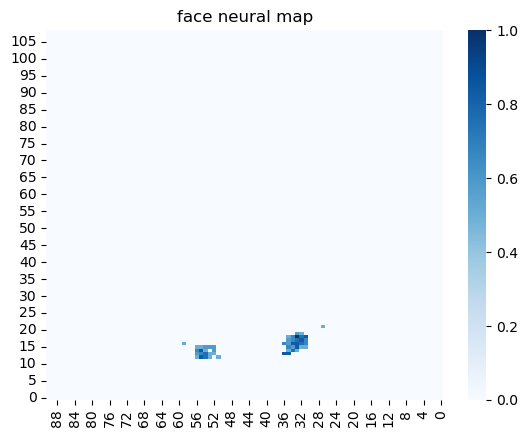

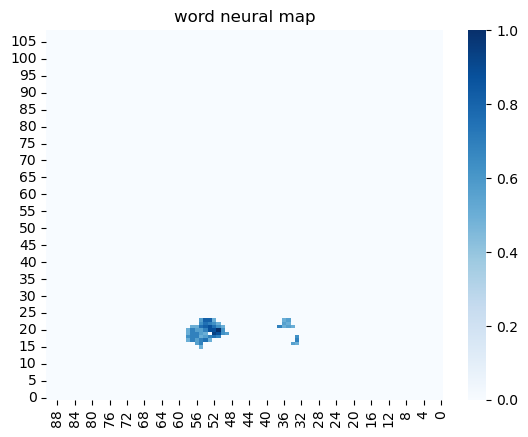

In [ ]:


    


#loop through tasks
for cond in task_info['cond']:
    #load map
    neural_map = np.load(f'{results_dir}/neural_map/{cond}_binary.npy')

    #convert to percent of max
    neural_map = neural_map/np.max(neural_map)

    #keep top 10%
    neural_map[neural_map < .5] = 0


    ax = sns.heatmap(neural_map, cmap='Blues')

    #add title
    ax.set_title(f'{cond} neural map')

    #flip y axis
    ax.invert_yaxis()
    #flip x axis
    ax.invert_xaxis()
    plt.show()
    

In [ ]:
sub = 'sub-hemispace2001'
task = 'loc'
cond = 'word'
parcel = 'ventral_visual_cortex'
cope = 4

sub_dir = f'{data_dir}/{sub}/ses-01'

roi = image.load_img(f'{roi_dir}/{parcel}.nii.gz')
#binarize roi
roi = image.math_img('img > 0', img=roi)

anat = image.load_img(f'{sub_dir}/anat/{sub}_ses-01_T1w_brain.nii.gz')


In [ ]:
word_zstat = image.load_img(f'{sub_dir}/derivatives/fsl/{task}/HighLevel.gfeat/cope4.feat/stats/zstat1_reg.nii.gz')
face_zstat = image.load_img(f'{sub_dir}/derivatives/fsl/{task}/HighLevel.gfeat/cope1.feat/stats/zstat1_reg.nii.gz')



In [ ]:
#mask zstat with roi
word_zstat = image.math_img('img1 * img2', img1=word_zstat, img2=roi)
face_zstat = image.math_img('img1 * img2', img1=face_zstat, img2=roi)

#threshold zstat at top 10%
word_zstat = image.threshold_img(word_zstat, threshold="99.9%", two_sided=False)
face_zstat = image.threshold_img(face_zstat, threshold="99.9%", two_sided=False)


In [ ]:
#convert zstat to numpy
word_func = word_zstat.get_fdata()
face_func = face_zstat.get_fdata()

#replace 0s with nan
#word_func[word_func==0] = np.nan
#face_func[face_func==0] = np.nan

#average across voxels in z dimension
word_func = np.transpose(np.max(word_func, axis=2))
face_func = np.transpose(np.max(face_func, axis=2))





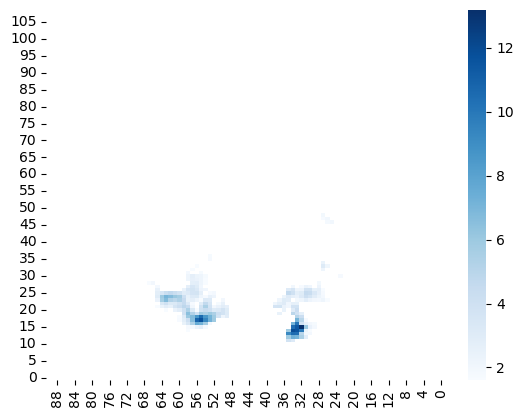

In [ ]:
#flip y axis 
ax = sns.heatmap(word_func, cmap='Blues')

#flip y axis
ax.invert_yaxis()
#flip x axis
ax.invert_xaxis()

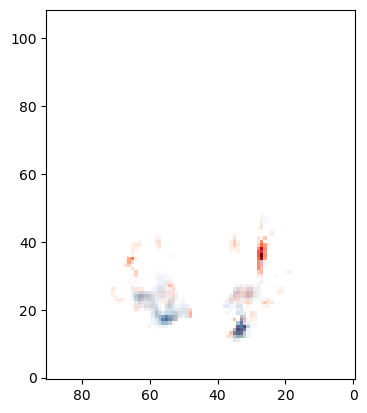

In [ ]:
#replace 0s with nan
face_func[face_func==0] = np.nan
word_func[word_func == 0] = np.nan

plt.imshow(face_func, cmap='Reds')
plt.imshow(word_func, cmap='Blues', alpha=0.7)
#flip y axis
plt.gca().invert_yaxis()
#flip x axis
plt.gca().invert_xaxis()

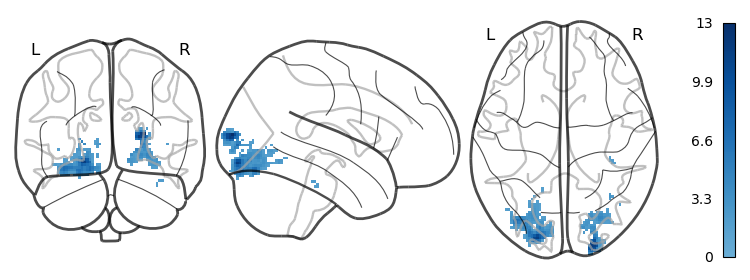

In [ ]:
plotting.plot_glass_brain(word_zstat, colorbar=True, plot_abs=False, cmap='Blues')


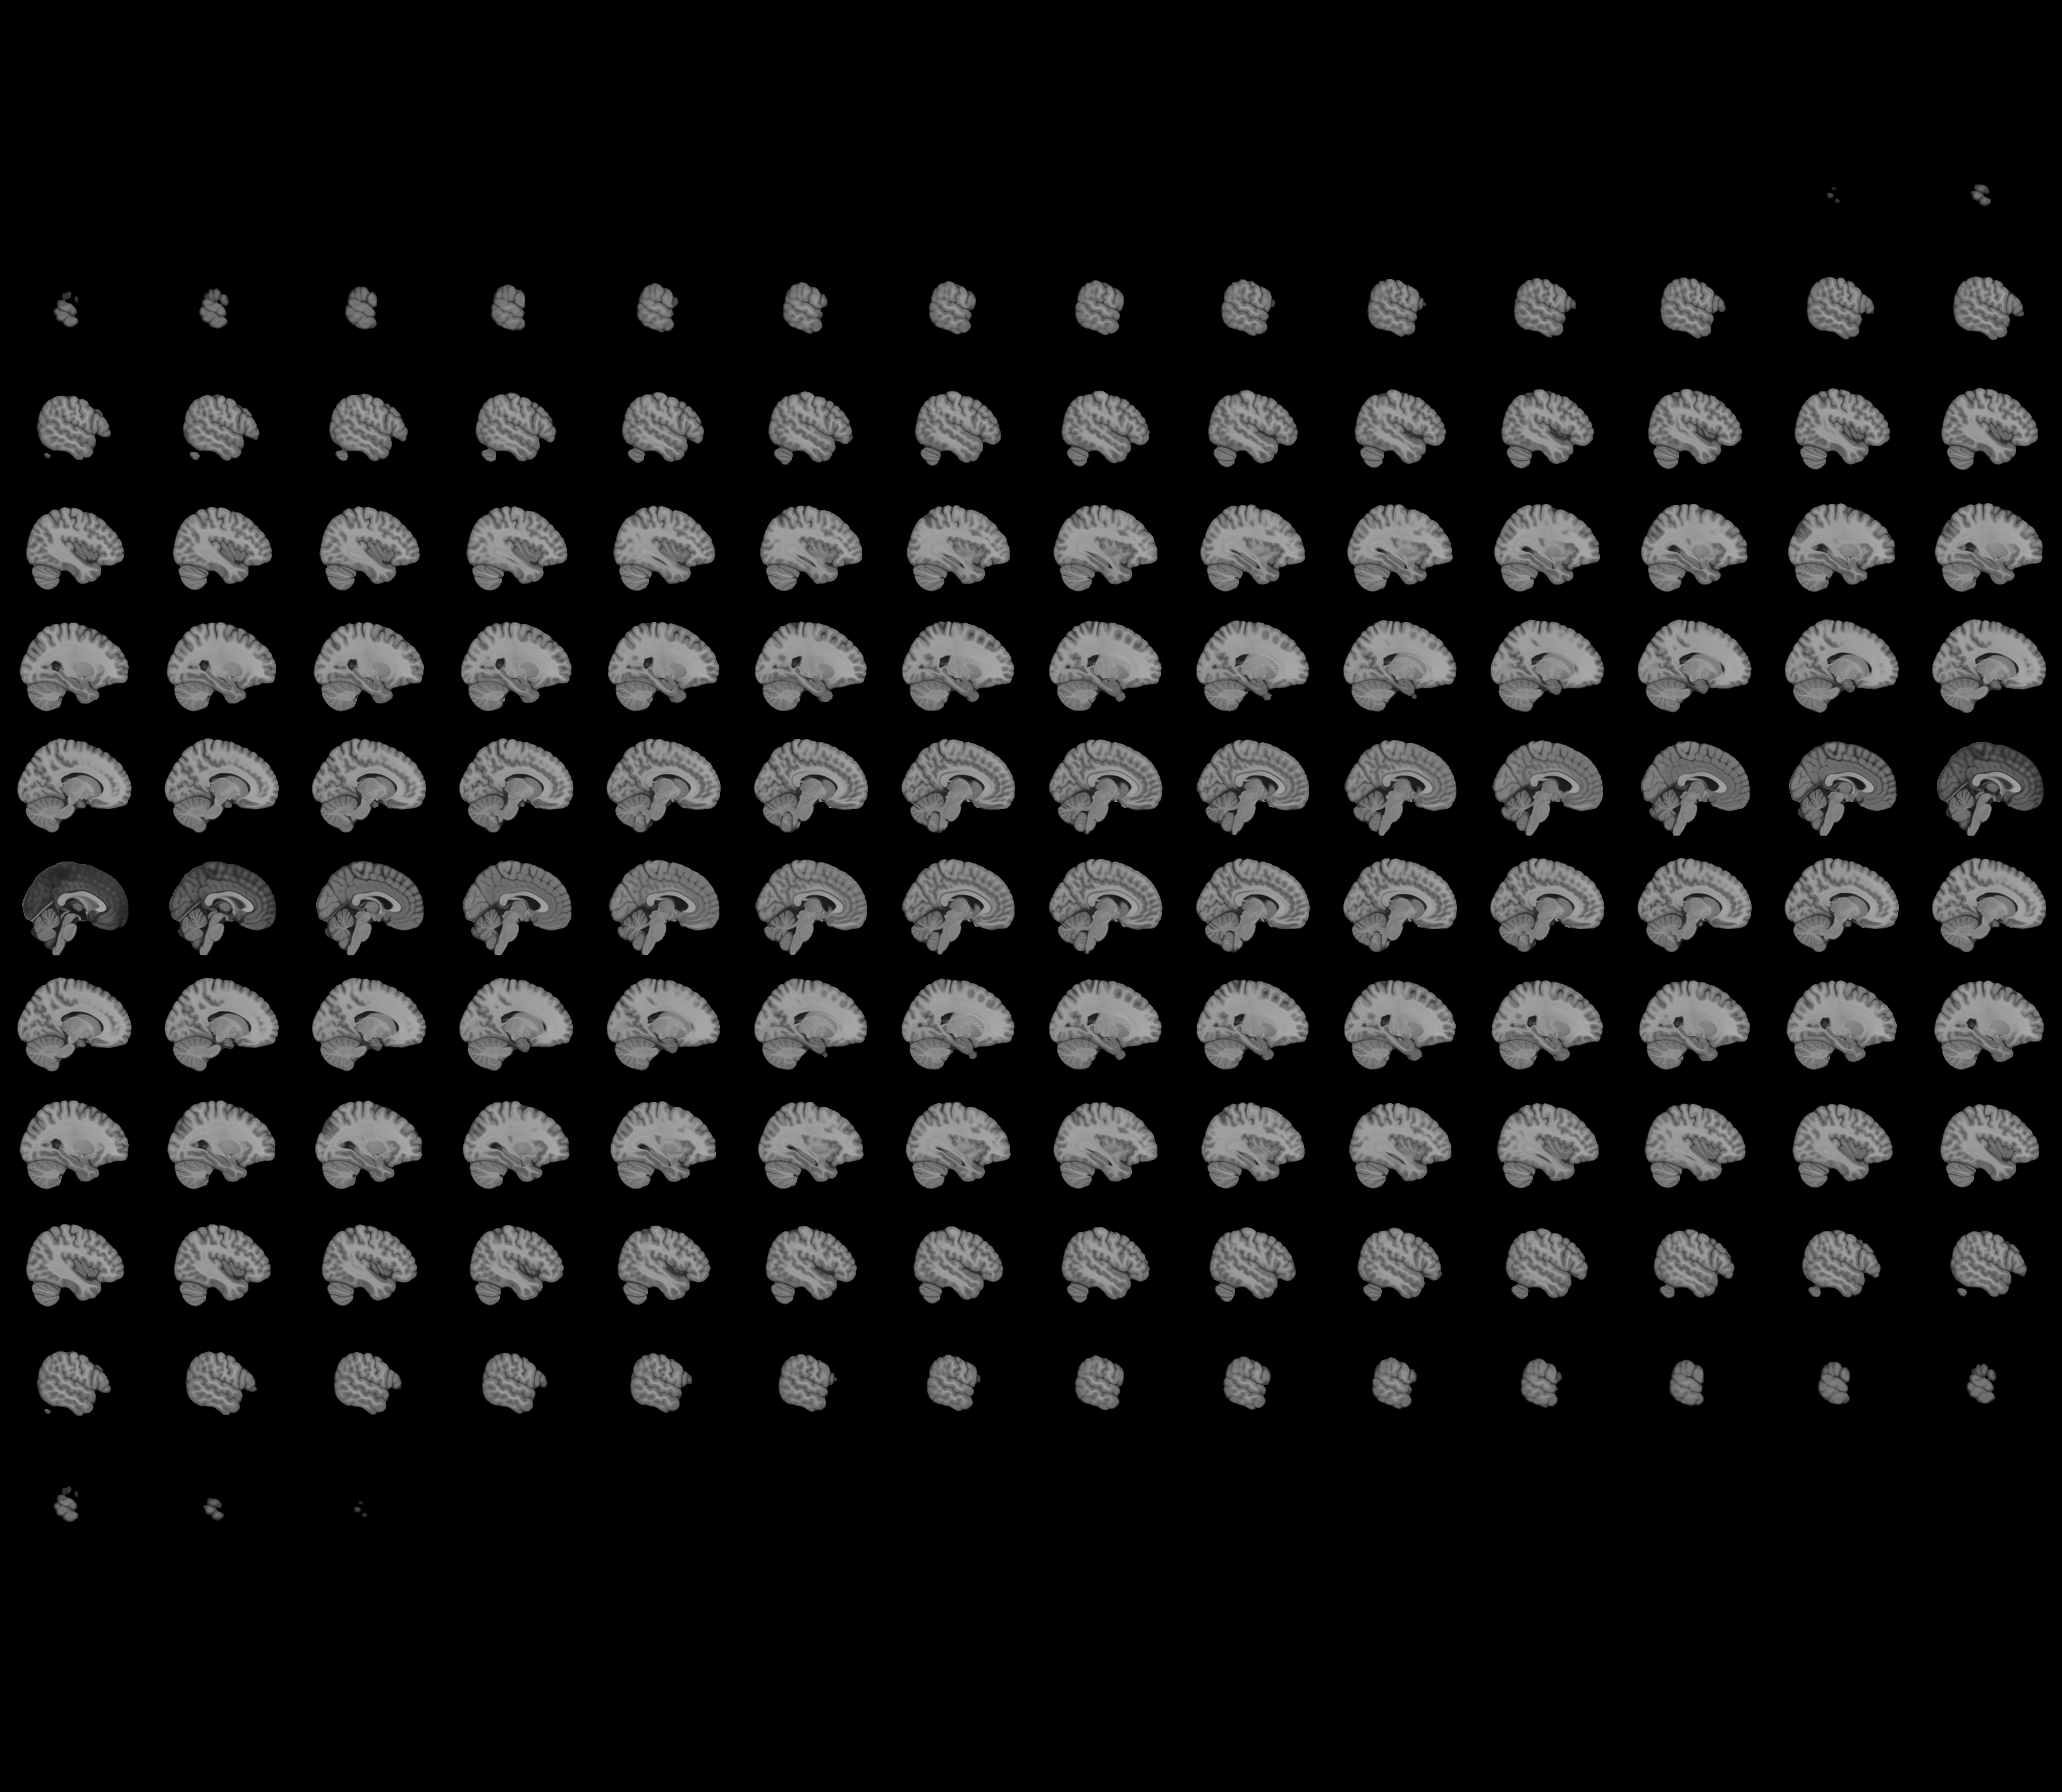
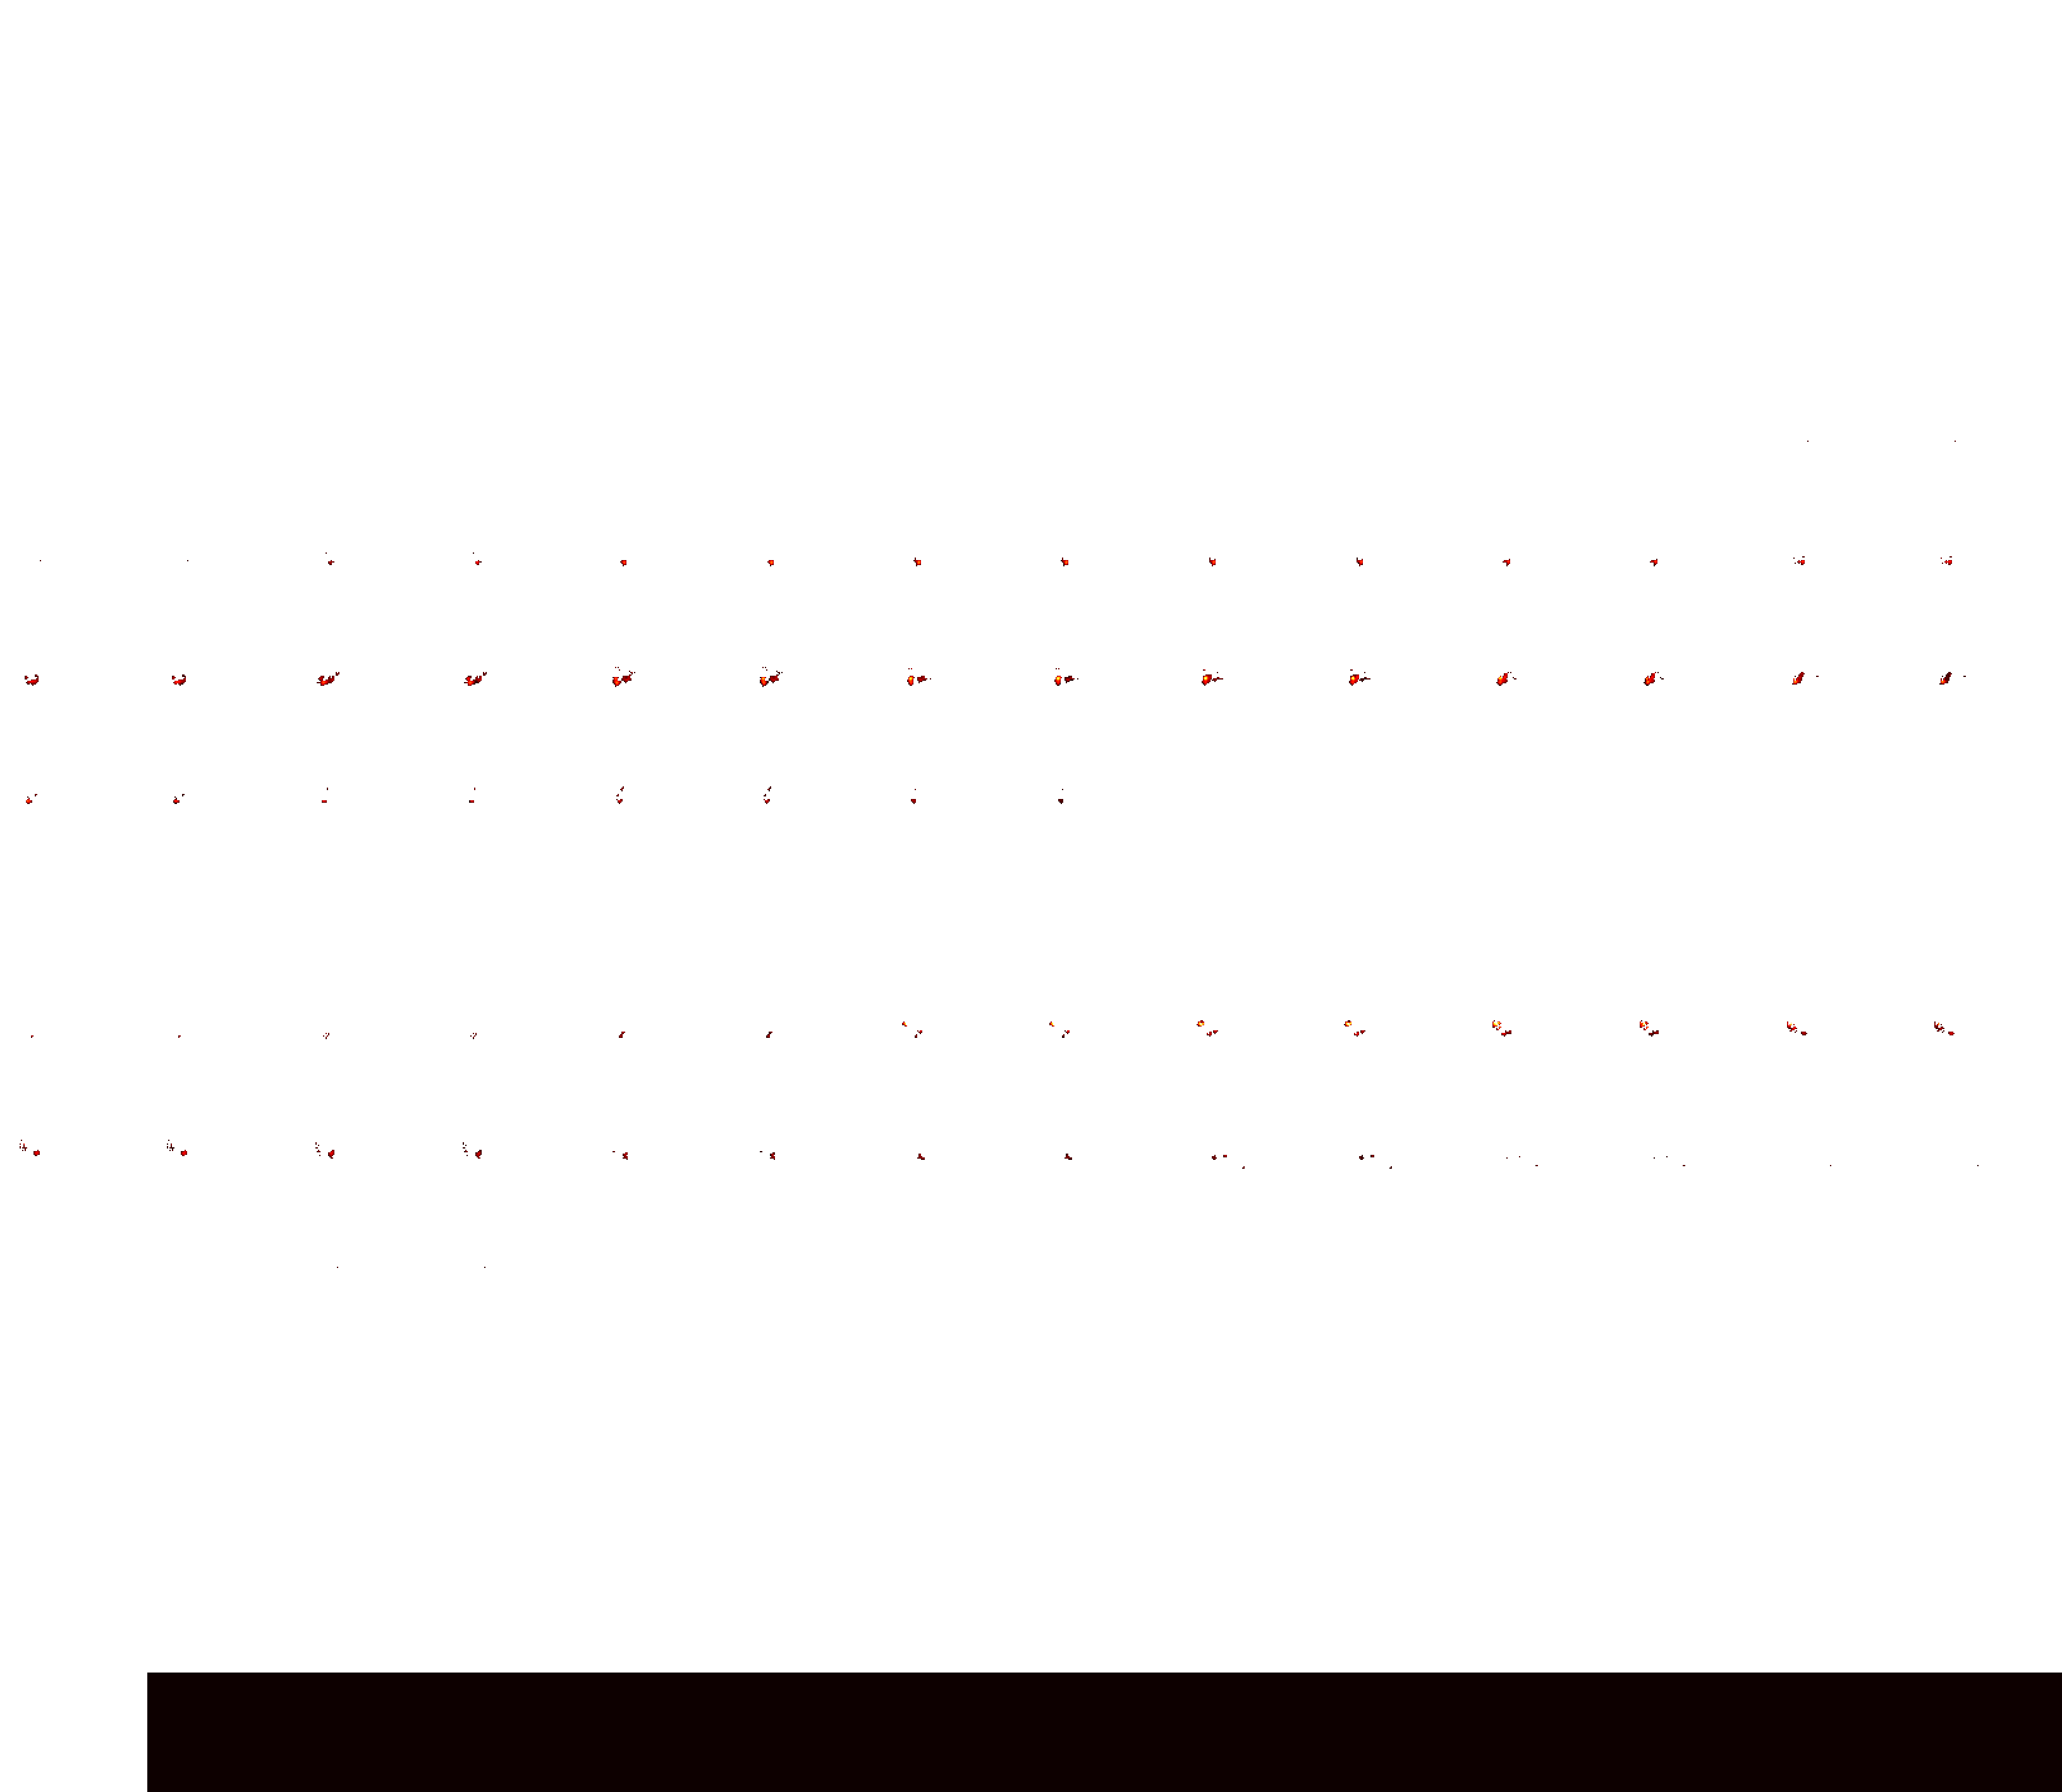

In [ ]:
plotting.view_img(word_zstat)

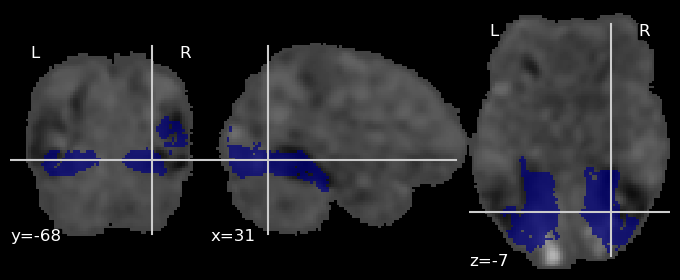

In [ ]:
plotting.plot_roi(roi_img = roi, bg_img=zstat)


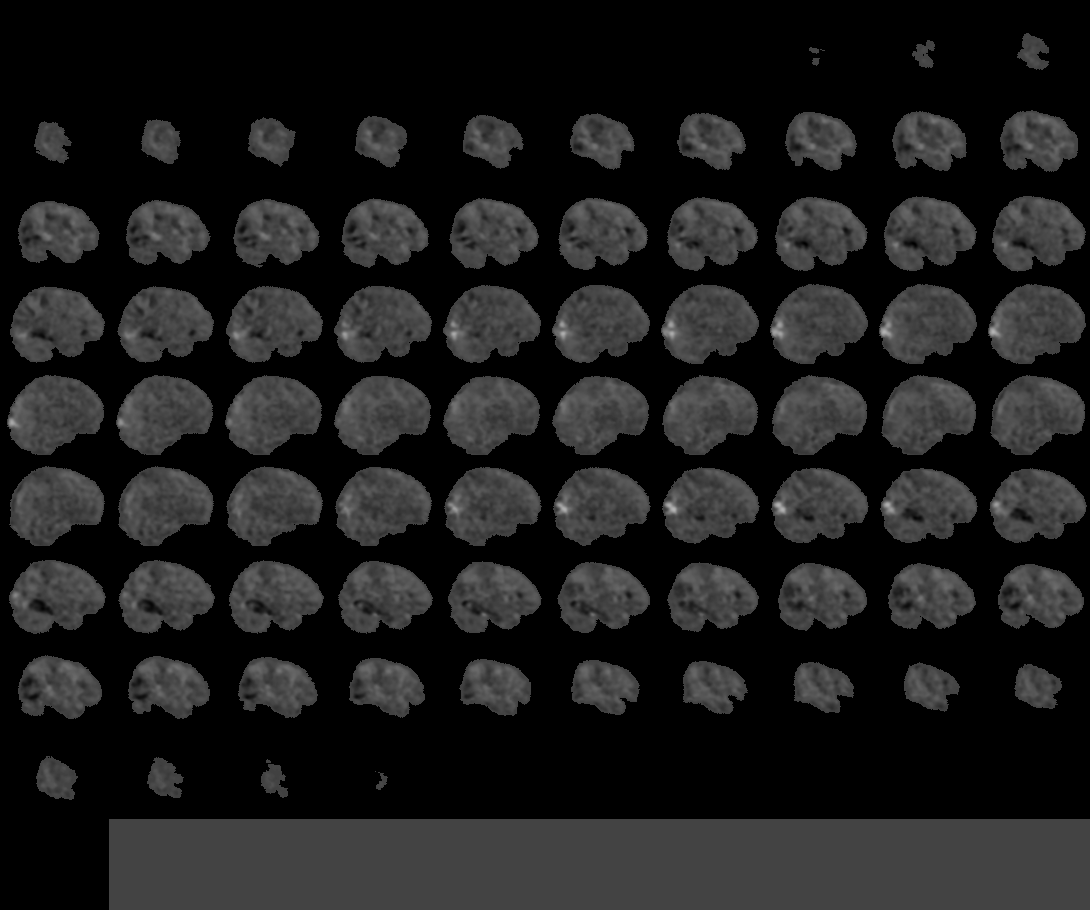
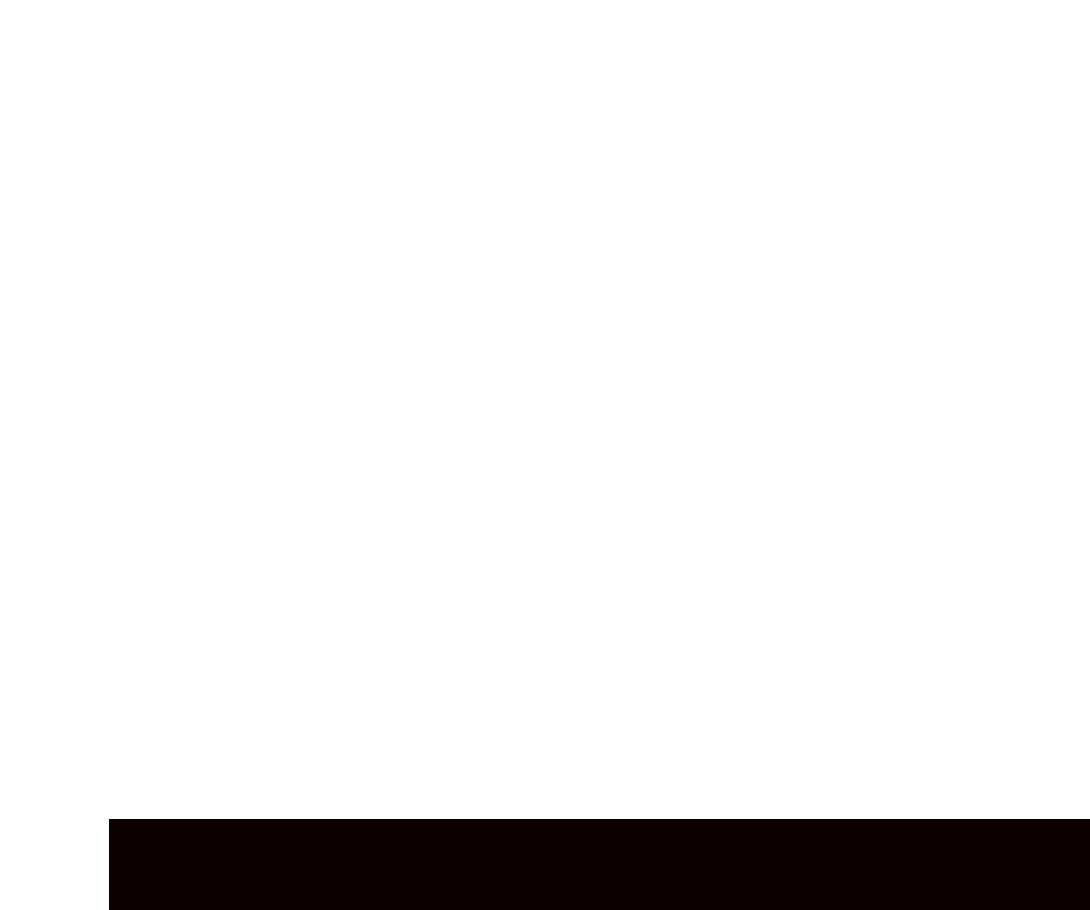

In [ ]:
plotting.view_img(roi, bg_img= zstat, title=f'{sub} {task} {cond} {cope}')